# Sign Language Digits

### Notebook Imports

In [1]:
import numpy as np

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Activation, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import imagenet_utils

from sklearn.metrics import confusion_matrix
import itertools
import os
import shutil
import random
import glob
import matplotlib.pyplot as plt
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


### Organizing data into Train, Valid, Test dirs

In [2]:
input_folder = '/kaggle/input/signlanguagedigitsdataset/Dataset'
output_folder = '/kaggle/working/dataset'

# Create the output folder if it doesn't exist
os.makedirs(output_folder, exist_ok=True)

# Function to copy either a file or a directory
def copy_item(item_name):
    source_path = os.path.join(input_folder, item_name)
    destination_path = os.path.join(output_folder, item_name)
    if os.path.isfile(source_path):
        shutil.copy(source_path, destination_path)
    elif os.path.isdir(source_path):
        shutil.copytree(source_path, destination_path)

# List all items in the input folder (files and directories)
items_list = os.listdir(input_folder)

# Copy each item from the input to the output folder
for item_name in items_list:
    copy_item(item_name)

# Check if items are successfully copied
output_items = os.listdir(output_folder)
print(f"Items successfully copied to output folder: {output_items}")

Items successfully copied to output folder: ['0', '2', '6', '9', '7', '3', '1', '4', '8', '5']


In [3]:
os.chdir('/kaggle/working/dataset')
if os.path.isdir('train/0/') is False: 
    os.mkdir('train')
    os.mkdir('valid')
    os.mkdir('test')

    for i in range(0, 10):
        shutil.move(f'{i}', 'train')
        os.mkdir(f'valid/{i}')
        os.mkdir(f'test/{i}')

        valid_samples = random.sample(os.listdir(f'train/{i}'), 30)
        for j in valid_samples:
            shutil.move(f'train/{i}/{j}', f'valid/{i}')

        test_samples = random.sample(os.listdir(f'train/{i}'), 5)
        for k in test_samples:
            shutil.move(f'train/{i}/{k}', f'test/{i}')
os.chdir('../..')

In [4]:
train_path = '/kaggle/working/dataset/train'
valid_path = '/kaggle/working/dataset/valid'
test_path = '/kaggle/working/dataset/test'

In [5]:
train_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input).flow_from_directory(
    directory=train_path, target_size=(224,224), batch_size=10)

valid_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input).flow_from_directory(
    directory=valid_path, target_size=(224,224), batch_size=10)

test_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input).flow_from_directory(
    directory=test_path, target_size=(224,224), batch_size=10, shuffle=False)

Found 1712 images belonging to 10 classes.
Found 300 images belonging to 10 classes.
Found 50 images belonging to 10 classes.


### Modify Model

In [6]:
mobile = tf.keras.applications.mobilenet.MobileNet()

17225924/17225924 [==============================] - 1s 0us/step


In [7]:
mobile.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizati  (None, 112, 112, 32)      128       
 on)                                                             
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D  (None, 112, 112, 32)      288       
 )                                                               
                                                                 
 conv_dw_1_bn (BatchNormali  (None, 112, 112, 32

In [8]:
x = mobile.layers[-6].output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
output = Dense(units=10, activation='softmax')(x)

In [9]:
model = Model(inputs=mobile.input, outputs=output)

In [10]:
for layer in model.layers[:-23]:
    layer.trainable = False

In [11]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizati  (None, 112, 112, 32)      128       
 on)                                                             
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D  (None, 112, 112, 32)      288       
 )                                                               
                                                                 
 conv_dw_1_bn (BatchNormali  (None, 112, 112, 32)      128   

### Train the Model

In [12]:
model.compile(optimizer=Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [13]:
model.fit(x=train_batches, validation_data=valid_batches, epochs=10, verbose=2)

Epoch 1/10
172/172 - 11s - loss: 0.3811 - accuracy: 0.8873 - val_loss: 2.0355 - val_accuracy: 0.5467 - 11s/epoch - 63ms/step
Epoch 2/10
172/172 - 3s - loss: 0.0937 - accuracy: 0.9708 - val_loss: 0.1277 - val_accuracy: 0.9600 - 3s/epoch - 18ms/step
Epoch 3/10
172/172 - 3s - loss: 0.0491 - accuracy: 0.9801 - val_loss: 0.1218 - val_accuracy: 0.9600 - 3s/epoch - 19ms/step
Epoch 4/10
172/172 - 3s - loss: 0.0483 - accuracy: 0.9848 - val_loss: 0.0113 - val_accuracy: 1.0000 - 3s/epoch - 19ms/step
Epoch 5/10
172/172 - 3s - loss: 0.0359 - accuracy: 0.9860 - val_loss: 0.0179 - val_accuracy: 0.9933 - 3s/epoch - 19ms/step
Epoch 6/10
172/172 - 3s - loss: 0.0129 - accuracy: 0.9953 - val_loss: 0.1511 - val_accuracy: 0.9467 - 3s/epoch - 19ms/step
Epoch 7/10
172/172 - 3s - loss: 0.0043 - accuracy: 0.9994 - val_loss: 0.0034 - val_accuracy: 1.0000 - 3s/epoch - 19ms/step
Epoch 8/10
172/172 - 3s - loss: 0.0061 - accuracy: 0.9977 - val_loss: 0.0114 - val_accuracy: 0.9967 - 3s/epoch - 19ms/step
Epoch 9/10
172

### Predict sign language digits

In [14]:
test_labels = test_batches.classes
test_batches.classes

array([0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 4, 4,
       4, 4, 4, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7, 8, 8, 8, 8,
       8, 9, 9, 9, 9, 9], dtype=int32)

In [15]:
predictions = model.predict(x=test_batches, verbose=0)

In [16]:
cm = confusion_matrix(y_true=test_labels, y_pred=predictions.argmax(axis=-1))

In [17]:
test_batches.class_indices

{'0': 0,
 '1': 1,
 '2': 2,
 '3': 3,
 '4': 4,
 '5': 5,
 '6': 6,
 '7': 7,
 '8': 8,
 '9': 9}

In [18]:
def plot_confusion_matrix(cm, classes, normalize=False, 
                          title="Confusion Matrix", cmap=plt.cm.Blues):
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap) 
    plt.title(title)
    plt.colorbar()
    
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print("Confusion Matrix, without normalization")
        
    print(cm)
    
    tresh = cm.max() / 2.
    
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j], horizontalalignment='center',
                color='white' if cm[i, j] > tresh else "black")
        
        plt.tight_layout()
        plt.ylabel("True Label")
        plt.xlabel("Predicted Label")

Confusion Matrix, without normalization
[[5 0 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0]
 [0 0 5 0 0 0 0 0 0 0]
 [0 0 0 5 0 0 0 0 0 0]
 [0 0 0 0 5 0 0 0 0 0]
 [0 0 0 0 0 5 0 0 0 0]
 [0 0 0 0 0 0 5 0 0 0]
 [0 0 0 0 0 0 0 5 0 0]
 [0 0 0 0 0 0 0 0 5 0]
 [0 0 0 0 0 0 0 0 0 5]]


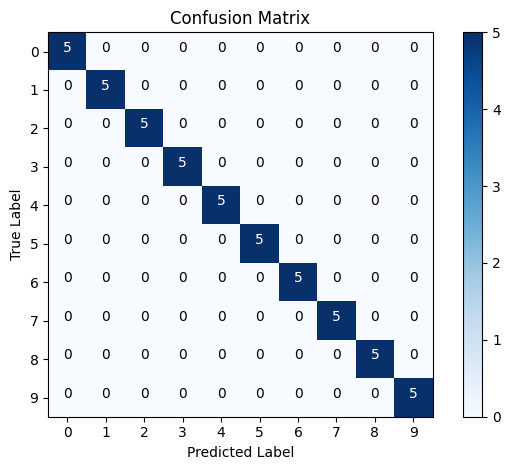

In [19]:
cm_plot_labels = [f'{i}' for i in range(0, 10)]
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')